### Проект
Суть: создать модель, которая определяла бы тональность финансовой новости, чтобы в дальнейшем использовать эту тональность как индекс для торговли на бирже
Подход: Был взят англоязычный датасет FinancialPhrases, который был переведен на русский язык. Данный датасет размечен профессиональными финансистами на тональности.
Идея: экстраполировать на работу с русскими источниками.
Источники собирались собственноручно, однако они используются для написания статьи в университете, поэтому прикреплять сами источники не могу, однако в ноутбуке видны куски данных
P.S. Данная модель должна по идее работать на сервере с ограниченной мощностью, поэтому было решено писать кастомные легковесные модели, а не использовать bert.
Тут это не отражено, но при сравнении rubert и лучшей моей модели, выйгрышная разница берта была минимальна, однако обучался и работал он значительно дольше

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tqdm import tqdm

In [3]:
from gensim.models import Word2Vec

### Чтение данных для обучения модели

In [33]:
data = pd.read_csv('FinancialPhrase.csv')
data[data.sentiment==0].text.iloc[0]

'Международное предприятие электронной промышленности Elcoteq уволило десятки сотрудников со своего таллиннского предприятия; в отличие от предыдущих увольнений, предприятие заключило договоры с офисными работниками, сообщает ежедневная газета Postimees. '

In [37]:
data

,text,sentiment
0,"По словам Грана, компания не планирует перенос...",1
1,Технополис планирует поэтапно развивать террит...,1
2,Международное предприятие электронной промышле...,0
3,С новым производственным комплексом компания у...,2
4,Согласно обновленной стратегии компании на 200...,2
...,...,...
4650,LONDON MarketWatch -- Цены на акции в понедель...,0
4651,"Продажи пива ""Ринкускяй"" снизились на 6,5 проц...",1
4652,"Операционная прибыль снизилась с 68,8 млн. евр...",0
4653,Чистый оборот бумажного сегмента во втором ква...,0


Решается задача мультиклассовой классификации

In [5]:
data.text[data.sentiment==0].iloc[1]

'Миниатюрная ссылка выводит пользователей на мошеннический сайт, обещая, что пользователи могут заработать тысячи долларов, став рекламодателем Google ( NASDAQ : GOOG ) наличными . '

### Препроцессинг текста.
Данный этап выглядит избыточным, однако тексты действительно большие и парсились с источников, где присутствуют много изменений от авторов статей, от всего этого было необходимо почистить текст
P.S. Более эффективно использовать регулярки как во второй дз, однако этот проект делался заранее
Из всех текстов удалялись стоп слова

In [16]:
class preprocessor():
    def __init__(self, texts):
        self.texts = texts
        self.new_texts = []
    def main(self):
        new_texts = []
        for sentence in self.texts:
            temp_sentence = sentence.lower()
            temp_sentence = temp_sentence.replace('\t', ' ')
            temp_sentence = temp_sentence.replace('-', '')
            temp_sentence = temp_sentence.replace('—', ' ')
            temp_sentence = temp_sentence.replace('\r\n', ' ')
            temp_sentence = temp_sentence.replace('\n', ' ')
            temp_sentence = temp_sentence.replace('\r', ' ')
            temp_sentence = temp_sentence.replace('\xa0', ' ')
            temp_sentence = temp_sentence.replace('!', '')
            temp_sentence = temp_sentence.replace('не ', 'не')
            temp_sentence = temp_sentence.replace('.', '')
            temp_sentence = temp_sentence.replace('?', '')
            temp_sentence = temp_sentence.replace(',', '')
            temp_sentence = temp_sentence.replace(';', '')
            temp_sentence = temp_sentence.replace(':', '')
            temp_sentence = temp_sentence.replace('"', '')
            temp_sentence = temp_sentence.replace(' - ', '')
            temp_sentence = temp_sentence.replace('(', '')
            temp_sentence = temp_sentence.replace(')', '')
            temp_sentence = temp_sentence.replace('#', ' ')
            temp_sentence = temp_sentence.replace('@', '')
            temp_sentence = temp_sentence.replace('&', '')
            temp_sentence = temp_sentence.replace('%', ' процент ')
            temp_sentence = temp_sentence.replace('«', '')
            temp_sentence = temp_sentence.replace('»', '')
            temp_sentence = temp_sentence.replace('   ', '')
            temp_sentence = temp_sentence.replace('  ', '')
            temp_sentence = temp_sentence.replace('  ', '')
            split_sentence = temp_sentence.split(' ')
            for num_of_word in range(len(split_sentence)):
                if split_sentence[num_of_word] == "":
                    continue
                if split_sentence[num_of_word][0] == "$":
                    split_sentence[num_of_word] = 'цена_в_долларах'
                if split_sentence[num_of_word][-2:] == "-й":
                    split_sentence[num_of_word] = 'номер_по_счету'
                
                if split_sentence[num_of_word].isdigit():
                    check_year = int(split_sentence[num_of_word])
                    if check_year>1900 and check_year<2100:
                        split_sentence[num_of_word] = 'номер_года'
                    else:
                        split_sentence[num_of_word] = 'число'

            new_texts.append(split_sentence)
        self.new_texts = new_texts
        return(new_texts)
    def drop_stop_words(self):
        morph = pymorphy2.MorphAnalyzer()
        sw = stopwords.words("russian")
        new_texts = []
        for sentence_num in tqdm(range(len(self.new_texts))):
            new_sentence = []
            for token in self.new_texts[sentence_num]:
                if token not in sw:
                    new_sentence.append(morph.parse(token)[0].normal_form)
            new_texts.append(new_sentence)
        self.new_texts = new_texts
        return(new_texts)

In [17]:
texts_pr = preprocessor(np.array(data.text))
texts_pr.main()
preprocessed_texts = texts_pr.drop_stop_words()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4655/4655 [00:08<00:00, 525.51it/s]


### Загрузка боевых данных, для обучения W2V.
Это необходимо для качественного обучения данной модели. Ибо FinancialPhrases сам по себе является небольшим датасетом, который можно дообогатить боевыми данными

In [5]:
all_news = list(np.load('../newspr3.npy', allow_pickle=True))

In [8]:
np.array(all_news).shape

<ipython-input-8-96563a6fa0dd>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(all_news).shape


(85174,)

In [9]:
w2v_model = Word2Vec(min_count=3, window=5, size=100, sg=1)
w2v_model.build_vocab(all_news)
w2v_model.train(all_news, total_examples=len(all_news), epochs=w2v_model.epochs)

(42528971, 50072720)

In [14]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [13]:
w2v_model.wv.save('w2v.wordvectors')

In [15]:
ww = KeyedVectors.load('w2v.wordvectors', mmap='r')

In [18]:
ww['фондовый']

array([-0.07581645, -0.5128714 ,  0.24566302, -0.7980684 ,  0.3236102 ,
        0.6157878 , -0.59635556,  0.00649763, -0.6816085 ,  0.07082226,
        0.2273858 , -0.5499194 ,  0.24390061,  0.39678103,  0.11186777,
       -1.1177908 ,  0.21396928, -0.30018717,  0.08768582,  1.1681544 ,
        1.241613  ,  0.7619373 ,  0.48136365, -0.3935712 , -0.91161305,
       -0.6830255 , -0.22575016,  0.13961075,  0.40441942, -1.0528724 ,
       -0.13307463, -0.23911558,  0.134042  , -0.5379116 , -0.20124891,
       -0.17978483,  0.14343296, -0.01520712, -0.44743267, -0.78636444,
        0.9556801 , -0.6792769 , -0.6201619 ,  0.40881643,  1.0600833 ,
        0.07707624,  0.44328293, -0.03353289, -0.39486638, -0.59805083,
        0.35039696,  0.48223284,  0.4588789 ,  0.2193207 , -0.3918461 ,
        0.40655243, -0.83356935,  0.8394476 , -0.00470783,  0.307627  ,
       -0.62666   ,  0.74088293, -0.07536972, -0.2224016 ,  0.17686786,
        0.5948644 ,  0.01770956,  0.09050272,  0.06980012, -0.16

### Суммаризация w2v для самой базовой модели
В качестве базовых моделей сравнивались бустинг и дерево в определении тноальности по суммаризации word2vec

In [18]:
emb_size = 100
texts = []
for text in preprocessed_texts:
    q = np.zeros(emb_size)
    counter = 0
    for word in text:
        if word in w2v_model.wv.vocab.keys():
            counter += 1
            q += w2v_model.wv[word]
        if counter:
            q/=counter
    texts.append(q)

In [19]:
X = np.array(texts)
y = np.array(data.sentiment)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25)

### Обучение самой базовой модели

In [ ]:
base_clf = DecisionTreeClassifier(max_depth=3)
model = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.3)
model.fit(X_train, y_train)

### Базовый скор

In [16]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.28      0.12      0.17       152
           1       0.68      0.85      0.76       699
           2       0.42      0.29      0.34       313

    accuracy                           0.61      1164
   macro avg       0.46      0.42      0.43      1164
weighted avg       0.56      0.61      0.57      1164



##### Видно, что очень хорошая точность на 1 классе, так как он превалирует

In [25]:
base_clf = LogisticRegression(max_iter=1000)
model = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.3)
base_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [35]:
print(classification_report(y_test, base_clf.predict(X_test), zero_division=True))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       151
           1       0.58      1.00      0.74       676
           2       1.00      0.00      0.01       337

    accuracy                           0.58      1164
   macro avg       0.86      0.33      0.25      1164
weighted avg       0.76      0.58      0.43      1164



### Результаты также не радуют

### Напишем полносвязную нейронку

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline 

In [28]:
from torch.utils.data import Dataset, DataLoader

In [19]:
class FCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fun = nn.Softmax()
    def forward(self, x):
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return(x)
    def get_loss(self, X, y):
        weight = torch.tensor([((y!=0).int()).sum()/(((y==0).int()).sum()),
                  ((y!=1).int()).sum()/(((y==1).int()).sum()),
                  ((y!=2).int()).sum()/(((y==2).int()).sum())])
        pred = self.forward(X)
        y = y.clone().detach()
        loss = nn.CrossEntropyLoss(weight=weight)
        return(loss(pred, y))

In [ ]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = y
    def __len__(self):
        return(self.X.shape[0])
    def __getitem__(self, idx):
        return(self.X[idx], self.y[idx])

In [30]:
X = np.array(texts)
y = np.array(data.sentiment)

In [22]:
num_epochs = 30
batch_size = 100
lr = 1e-4
train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
model = FCNN(X.shape[1], 3)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=lr)


In [23]:
train_losses = []
val_losses = []

##### Тут можно было бы вынести обучение в отдельную функцию, так и будет сделано в следующих доработках

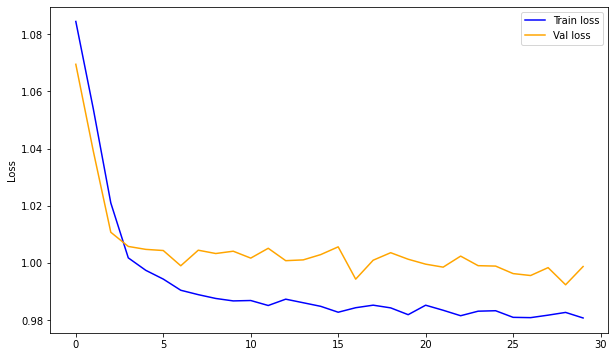

In [122]:
for i in range(num_epochs):
    train_loss=0
    val_loss = 0
    model.train(True)
    for X, y in train_dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(X, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    model.train(False)
    for X, y in test_dataloader:
        loss = model.get_loss(X, y)
        val_loss+=loss/len(test_dataloader)
    val_losses.append(val_loss)
    
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

In [123]:
preds = model.forward(torch.tensor(X_test).float())
preds.argmax(axis=1).max()

tensor(1)

In [124]:
print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))

              precision    recall  f1-score   support

           0       0.12      0.91      0.21       140
           1       0.74      0.13      0.22       692
           2       1.00      0.00      0.00       332

    accuracy                           0.19      1164
   macro avg       0.62      0.35      0.14      1164
weighted avg       0.74      0.19      0.16      1164



### Поиграем со сложными нейронками

##### На вход будем подавать масиив массивов, отформатированный для стандарной подачи в нейронные сети attention, self-attenion, one-layer-transformer
далее идет однообразный код для выявления лучше модели для решения задачи

In [31]:
emb_size = 100
full_texts = []
for text in preprocessed_texts:
    sentence = []
    q = np.ones(emb_size)
    for word in text:
        if word in w2v_model.wv.vocab.keys():
            sentence.append(w2v_model.wv[word])
        else:
            sentence.append(q)
    full_texts.append(sentence)

In [32]:
max_length = np.array([len(x) for x in full_texts]).max()

In [33]:
format_full_text = []
for text in full_texts:
    temp = np.zeros((45, 100))
    temp[-len(text):] = text
    format_full_text.append(temp)

In [34]:
format_full_text = np.array(format_full_text)

In [35]:
batch_size = 100

X = np.array(format_full_text)
y = np.array(data.sentiment)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25)

train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)

#### Attention network

In [36]:
class attention(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(attention, self).__init__()
        self.find_weight = nn.Linear(input_shape, 1)
        self.linear1 = nn.Linear(input_shape, 80)
        self.linear2 = nn.Linear(80, 30)
        self.linear3 = nn.Linear(30, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        y = self.dropout(x)
        weight = self.find_weight(y).squeeze(-1)
        norm_weight = self.softmax(weight).unsqueeze(1)
        weighted = torch.matmul(norm_weight, x).squeeze(1)
        output = self.dropout(weighted)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.linear2(output)
        output = self.relu(output)
        output = self.linear3(output)
        return(output)
    def get_loss(self, X, y):
        weight = torch.tensor([((y!=0).int()).sum()/(((y==0).int()).sum()),
                  ((y!=1).int()).sum()/(((y==1).int()).sum()),
                  ((y!=2).int()).sum()/(((y==2).int()).sum())])
        pred = self.forward(X)
        y = y.clone().detach()
        loss = nn.CrossEntropyLoss(weight=None)
        return(loss(pred, y))

In [37]:
m = attention(100, 3)

In [38]:
m.forward(next(iter(train_dataloader))[0]).shape

torch.Size([100, 3])

In [39]:
x1, y1 = next(iter(train_dataloader))
m.get_loss(x1, y1)

tensor(1.0725, grad_fn=<NllLossBackward>)

In [46]:
X.shape[-1]

100

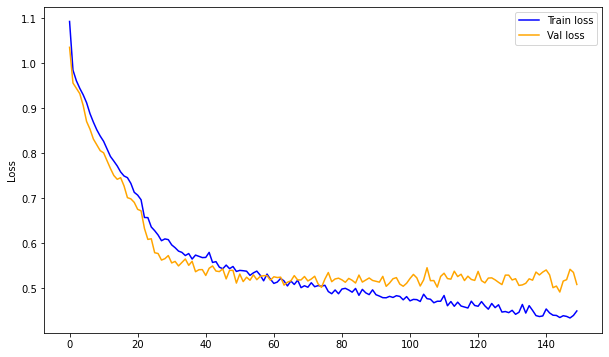

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       132
           1       0.85      0.86      0.85       715
           2       0.69      0.65      0.67       317

    accuracy                           0.79      1164
   macro avg       0.73      0.74      0.74      1164
weighted avg       0.78      0.79      0.78      1164



In [40]:
num_epochs = 150
batch_size = 200
lr = 1e-3
train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
model = attention(X.shape[-1], 3)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=lr)

train_losses = []
val_losses = []

for i in range(num_epochs):
    train_loss=0
    val_loss = 0
    model.train(True)
    for X, y in train_dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(X, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    model.train(False)
    for X, y in test_dataloader:
        loss = model.get_loss(X, y)
        val_loss+=loss/len(test_dataloader)
    val_losses.append(val_loss)
    
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    preds = model.forward(torch.tensor(X_test).float())
    print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))

In [45]:
torch.save(model.state_dict(), 'attention_network.pth')

In [41]:
preds = model.forward(torch.tensor(X_test).float())
preds.argmax(axis=1).max()

tensor(2)

In [55]:
nn.Softmax(dim=-1)(preds)

tensor([[0.0122, 0.6586, 0.3293],
        [0.0638, 0.8923, 0.0439],
        [0.1958, 0.7027, 0.1015],
        ...,
        [0.5712, 0.4214, 0.0075],
        [0.4808, 0.4733, 0.0459],
        [0.0206, 0.1993, 0.7801]], grad_fn=<SoftmaxBackward>)

In [42]:
print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       132
           1       0.85      0.86      0.85       715
           2       0.69      0.65      0.67       317

    accuracy                           0.79      1164
   macro avg       0.73      0.74      0.74      1164
weighted avg       0.78      0.79      0.78      1164



#### self-attention networks

In [38]:
class self_attention(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(self_attention, self).__init__()
        self.find_weight = nn.Linear(input_shape, 1)
        self.linear1 = nn.Linear(input_shape, 80)
        self.linear2 = nn.Linear(80, 30)
        self.linear3 = nn.Linear(30, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        self.weight_softmax = nn.Softmax(dim=1)
    def forward(self, x):
        logits = torch.matmul(torch.transpose(x, 1,2), x)
        scores = self.weight_softmax(logits)
        scored_x = torch.matmul(x, scores)
        y = self.dropout(scored_x)
        weight = self.find_weight(y).squeeze(-1)
        norm_weight = self.softmax(weight).unsqueeze(1)
        weighted = torch.matmul(norm_weight, scored_x).squeeze(1)
        output = self.dropout(weighted)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.linear2(output)
        output = self.relu(output)
        output = self.linear3(output)
        return(output)
    def get_loss(self, X, y):
        weight = torch.tensor([((y!=0).int()).sum()/(((y==0).int()).sum()),
                  ((y!=1).int()).sum()/(((y==1).int()).sum()),
                  ((y!=2).int()).sum()/(((y==2).int()).sum())])
        pred = self.forward(X)
        y = y.clone().detach()
        loss = nn.CrossEntropyLoss(weight=None)
        return(loss(pred, y))

In [39]:
m = self_attention(100, 3)
num_epochs = 150
batch_size = 100
lr = 1e-3
train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)

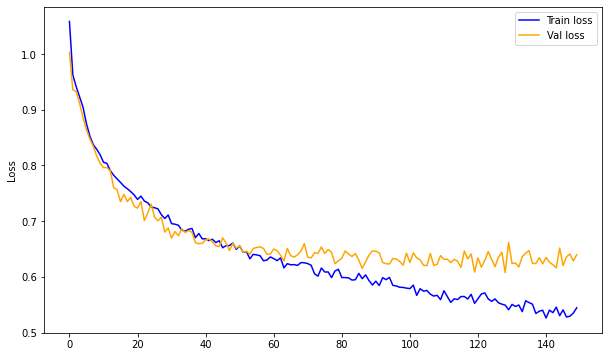

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       139
           1       0.80      0.89      0.85       692
           2       0.70      0.45      0.55       333

    accuracy                           0.74      1164
   macro avg       0.67      0.67      0.65      1164
weighted avg       0.74      0.74      0.73      1164



In [40]:
num_epochs = 150
batch_size = 200
lr = 1e-3
train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
model = self_attention(X.shape[-1], 3)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=lr)



train_losses = []
val_losses = []

for i in range(num_epochs):
    train_loss=0
    val_loss = 0
    model.train(True)
    for X, y in train_dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(X, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    model.train(False)
    for X, y in test_dataloader:
        loss = model.get_loss(X, y)
        val_loss+=loss/len(test_dataloader)
    val_losses.append(val_loss)
    
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    preds = model.forward(torch.tensor(X_test).float())
    print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))

In [41]:
data.text[data.sentiment==0].iloc[250]

'Большая часть постоянных сокращений будет приходиться на фанерный и лесопильный секторы деятельности финской компании на нескольких отечественных фабриках, где в начале этого года она временно уволила около 1200 работников для экономии затрат. '

In [42]:
preds = model.forward(torch.tensor(X_test).float())
preds.argmax(axis=1).max()

tensor(2)

In [43]:
print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       139
           1       0.80      0.89      0.85       692
           2       0.70      0.45      0.55       333

    accuracy                           0.74      1164
   macro avg       0.67      0.67      0.65      1164
weighted avg       0.74      0.74      0.73      1164



### Будем использовать attention network+w2v для определения тональности, поскольку он показывает себя лучше всего

Ниже приведен пример использования данной нейронной сети для реальных предсказаний. Код ниже помогает для определения повысится ли цена определенной акции после выхода новости.

In [26]:
import os

Препроцессинг финансовых новостей, и котировок акций соответствующих этим новостям компаний

In [27]:
complete = pd.DataFrame()
for file in os.listdir('../merged'):
        temp_df = pd.read_csv('../merged/'+file).rename(columns={
                '<TICKER>': 'ticker',
                '<PER>' : 'per',
                '<DATE>': 'date',
                '<TIME>': 'time',
                '<OPEN>': 'open', 
                '<HIGH>': 'high',
                '<LOW>': 'low',
                '<CLOSE>': 'close',
                '<VOL>': 'vol'
            })
        next_high = temp_df['high'][1:].reset_index()['high']
        next_low = temp_df['low'][1:].reset_index()['low']
        temp_df = temp_df[:-1]
        temp_df['next_high'] = next_high
        temp_df['next_low'] = next_low
        temp_df = temp_df.dropna()
        complete = complete.append(temp_df)

In [28]:
complete.header

0       Акции "Абрау-Дюрсо" допущены к торгам на ММВБ-РТС
7       "Абрау - Дюрсо" не планирует выплачивать дивид...
11      ГОСА "Абрау-Дюрсо" состоится 20 июня 2012 года...
13      События предстоящих дней: Дмитрий Медведев при...
48      События предстоящего дня: ГОСА "Роснефти", "Ба...
                              ...                        
375     Собянин: Реорганизация промзоны бывшего автоза...
702     Имущество "ЗИЛа" повторно выставлено на торги ...
750     "Группа ЛСР" и АФК "Система" выиграли конкурс ...
595     События предстоящего дня: Путин примет участие...
1298    "НОВАТЭК" построит 15 танкеров ледового класса...
Name: header, Length: 85155, dtype: object

In [30]:
from tqdm import tqdm

In [31]:
header_pr = preprocessor(np.array(complete.header))
header_pr.main()
preprocessed_headers = header_pr.drop_stop_words()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85155/85155 [01:51<00:00, 762.43it/s]


In [32]:
emb_size = 100
full_texts = []
for text in preprocessed_headers:
    sentence = []
    q = np.ones(emb_size)
    for word in text:
        if word in w2v_model.wv.vocab.keys():
            sentence.append(w2v_model.wv[word])
        else:
            sentence.append(q)
    full_texts.append(sentence)

In [33]:
max_length = np.array([len(x) for x in full_texts]).max()

In [34]:
format_full_text = []
for text in full_texts:
    temp = np.zeros((max_length, 100))
    temp[-len(text):] = text
    format_full_text.append(temp)

In [35]:
X_full = np.array(format_full_text)

In [70]:
targ = (complete.close>complete.open).astype(int)

In [71]:
X_train, X_test, y_train, y_test = train_test_split( X_full, np.array(targ), test_size=0.25)

In [72]:
X_train.shape

(63866, 34, 100)

#### трейн никак не использовался, так как он использовался для обучения моделей основанных чисто на данныых ккотировок. Уже не тут

In [47]:
qq = pd.DataFrame({'pred': nn.Softmax(dim=-1)(model.forward(torch.tensor(X_test).float())).detach().numpy()[:, 1], 
              'real': y_test})

In [63]:
qq.sort_values("pred", ascending=False).iloc[:20000].real.sum()

6793

### Во время реального использования, метрика выбранная для данной задачи (precision@k) показала хорошую точность для решения задачи, это порядка 7000 новостей из 20000 самых больших по вероятности, после выхода которых акции сильно пошли вверх. При детальном погружении в задчу оказывается, что это действительно очень хорший результат, поскольку большинство реально выходящих финансовых новостей абсолютно нейтральны

#### one_layer_transformer
Нужно отметить, что его запустить не получилось, так как он съедал слишком много видеопамяти при обучении

In [48]:
class one_layer_transformer(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(one_layer_transformer, self).__init__()
        
        self.linear_for_queries = nn.Linear(input_shape, input_shape)
        self.linear_for_keys = nn.Linear(input_shape, input_shape)
        self.linear_for_values = nn.Linear(input_shape, input_shape)
        
        self.find_weight = nn.Linear(input_shape, 1)
        self.linear1 = nn.Linear(input_shape, 80)
        self.linear2 = nn.Linear(80, 30)
        self.linear3 = nn.Linear(30, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        self.weight_softmax = nn.Softmax(dim=1)
    def forward(self, x):
        
        queries = self.linear_for_queries(x)
        keys = self.linear_for_keys(x)
        values = self.linear_for_values(x)

        
        logits = torch.matmul(torch.transpose(queries, 1,2), keys)
        scores = self.weight_softmax(logits)
        scored_x = torch.matmul(values, scores)
        
        y = self.dropout(scored_x)
        weight = self.find_weight(y).squeeze(-1)
        norm_weight = self.softmax(weight).unsqueeze(1)
        weighted = torch.matmul(norm_weight, scored_x).squeeze(1)
        output = self.dropout(weighted)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.linear2(output)
        output = self.relu(output)
        output = self.linear3(output)
        return(output)
    def get_loss(self, X, y):
        weight = torch.tensor([((y!=0).int()).sum()/(((y==0).int()).sum()),
                  ((y!=1).int()).sum()/(((y==1).int()).sum()),
                  ((y!=2).int()).sum()/(((y==2).int()).sum())])
        pred = self.forward(X)
        y = y.clone().detach()
        loss = nn.CrossEntropyLoss(weight=None)
        return(loss(pred, y))

In [49]:
torch.set_default_tensor_type(torch.FloatTensor)

In [50]:
m=one_layer_transformer(100, 3)
m.forward(next(iter(train_dataloader))[0]).shape

torch.Size([100, 3])

In [ ]:
num_epochs = 200
batch_size = 100
lr = 1e-4
train_dataset = dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataset = dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
model = one_layer_transformer(X.shape[-1], 3)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=lr)

train_losses = []
val_losses = []

for i in range(num_epochs):
    train_loss=0
    val_loss = 0
    model.train(True)
    for X, y in train_dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(X, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    model.train(False)
    for X, y in test_dataloader:
        loss = model.get_loss(X, y)
        val_loss+=loss/len(test_dataloader)
    val_losses.append(val_loss)
    
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    preds = model.forward(torch.tensor(X_test).float())
    print(classification_report(y_test,preds.argmax(axis=1).detach().numpy(), zero_division=True))